In [1]:
import os
import fastbook
from fastbook import *

### Define search function that uses DuckDuckGo to scrape images from the internet

In [8]:
from fastai.vision.all import *
from fastdownload import download_url
from pandas.api.types import CategoricalDtype
from scipy.cluster import hierarchy as hc
from io import StringIO, BytesIO
from urllib.error import URLError,HTTPError
from time import sleep

def search_images_ddg(term, max_images=200):
    # "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

### Test search function

In [12]:
from IPython.display import Image, display

search_word="fusca"

urls = search_images_ddg(search_word, max_images=1)
!ls -A fusca_or_isetta/fusca | wc -l
display(Image(url=urls[0]))

In [13]:
from IPython.display import Image, display

search_word="Isetta"

urls = search_images_ddg(search_word, max_images=1)

display(Image(url=urls[0]))

### Save imgs found

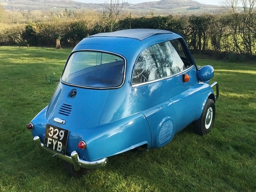

In [15]:
from PIL import Image

keyword = 'Isetta'
filename = keyword+'.jpg'
urls = search_images_ddg(keyword, max_images=1)
download_url(urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

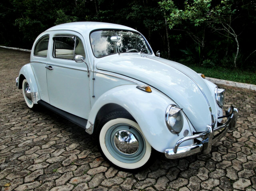

In [16]:
keyword = 'fusca'
filename = keyword+'.jpg'
urls = search_images_ddg(keyword, max_images=1)
download_url(urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

### Generate dataset of ims we want to categorize

In [18]:
categories = 'fusca','isetta'
path = Path(categories[0] + '_or_'+ categories[1])

for o in categories:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)


In [38]:
!ls -A fusca_or_isetta/isetta | wc -l

186


In [37]:
!ls -A fusca_or_isetta/fusca | wc -l

195


### Remove corrupted imgs

In [39]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

In [40]:
!ls -A fusca_or_isetta/isetta | wc -l

181


In [41]:
!ls -A fusca_or_isetta/fusca | wc -l

189


### I looked at the imgs and manually removed the ones that are not accurate

In [42]:
!ls -A fusca_or_isetta/isetta | wc -l

171


In [43]:
!ls -A fusca_or_isetta/fusca | wc -l

146


### Get a Random sample from the images that were downloaded

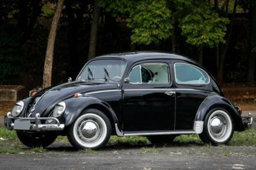

Category:fusca


In [44]:
downloaded_imgs = get_image_files(path)
total_imgs = len(downloaded_imgs)
rand = int(np.random.uniform(0,total_imgs))
filename = downloaded_imgs[rand]
im = Image.open(filename)

im.thumbnail((256, 256))
display(im)

print("Category:" + str(downloaded_imgs[rand]).split("/")[1])

### Run FastAI DataBlock

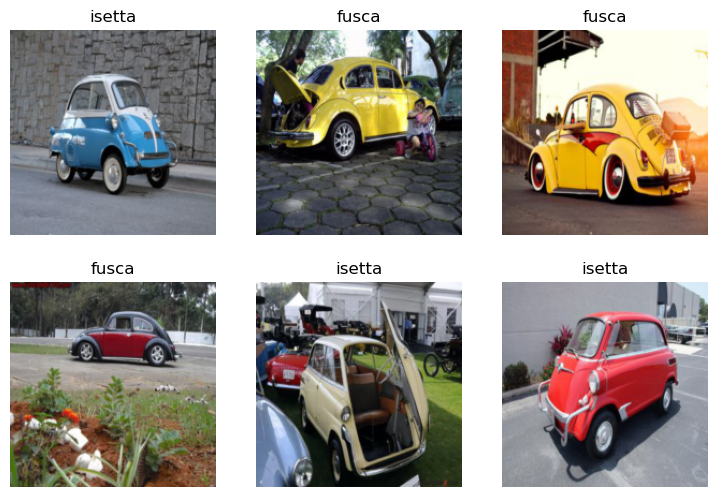

In [63]:
classic_cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

dls = classic_cars.dataloaders(path)

dls.show_batch(max_n=6, show=True)

In [67]:
classic_cars.summary(path)

Setting-up type transforms pipelines
Found 317 items
2 datasets of sizes 254,63
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      fusca_or_isetta/fusca/99.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=400x249
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      fusca_or_isetta/fusca/99.jpg
    applying parent_label gives
      fusca
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=400x249, TensorCategory(0))


Found 317 items
2 datasets of sizes 254,63
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (192, 192), 'method': 'squ

### Train our model

In [47]:
#from fastai.vision.all import *

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.038088,1.347060,0.428571,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.404768,0.358412,0.142857,00:18
1,0.274926,0.153207,0.047619,00:19
2,0.198945,0.162362,0.063492,00:20
3,0.147908,0.169845,0.063492,00:20


### Download new image to test our trained model

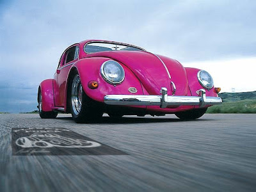

This is a: fusca.
Probability it's a fusca: 0.9977


In [48]:
test = 'pink_fusca'
filename = test + '.jpg'
urls = search_images_ddg(test, max_images=1)
download_url(urls[0], filename, show_progress=False)

im = Image.open(filename)
im.thumbnail((256, 256))
display(im)

cat,_,probs = learn.predict(PILImage.create(filename))
print(f"This is a: {cat}.")
print(f"Probability it's a {cat}: {probs[0]:.4f}")

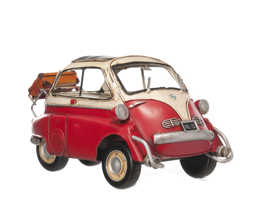

This is a: isetta.
Probability it's a isetta: 0.9991


In [50]:
test = 'romisetta'
filename = test + '.jpg'
urls = search_images_ddg(test, max_images=1)
download_url(urls[0], filename, show_progress=False)

im = Image.open(filename)
im.thumbnail((256, 256))
display(im)

cat,_,probs = learn.predict(PILImage.create(filename))
print(f"This is a: {cat}.")
print(f"Probability it's a {cat}: {probs[1]:.4f}")

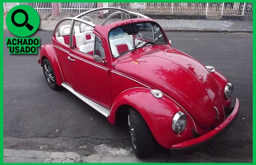

This is a: fusca.
Probability it's a fusca: 0.9926


In [54]:
test = 'fusca_conversivel'
filename = test + '.jpg'
urls = search_images_ddg(test, max_images=1)
download_url(urls[0], filename, show_progress=False)

im = Image.open(filename)
im.thumbnail((256, 256))
display(im)

cat,_,probs = learn.predict(PILImage.create(filename))
print(f"This is a: {cat}.")
print(f"Probability it's a {cat}: {probs[0]:.4f}")